# 👀 多層パーセプトロン (MLP)

In [8]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
from torch import nn
from torch.utils.data import DataLoader
import sys
print(sys.version)
print(torch.__version__)

3.11.10 (main, Sep 12 2024, 21:09:22) [GCC 10.2.1 20210110]
2.1.0+cu121


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


## 0. パラメータ

In [5]:
NUM_CLASSES = 10

## 1. データ準備

In [6]:
# CIFAR10のデータセットを読み込み
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

CLASSES = np.array([
        "飛行機",
        "自動車",
        "鳥",
        "猫",
        "鹿",
        "犬",
        "カエル",
        "馬",
        "船",
        "トラック"])

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

(3, 32, 32)


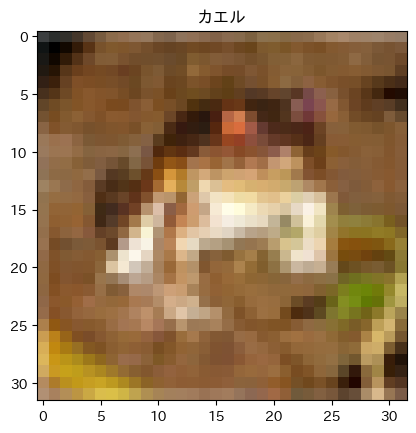

In [9]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[0][0].permute(1,2,0))
plt.title(CLASSES[trainset[0][1]])
plt.show()

## 2. モデル構築

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, num_classes):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [1]:
model = SimpleMLP(num_classes=NUM_CLASSES)

torchinfo.summary(model.eval(), input_size=(1, 3, 32, 32), verbose=0)

NameError: name 'SimpleMLP' is not defined

## 3. モデルの訓練

In [9]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [2]:
epochs = 20
model = model.to(device)
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    count = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward() # backpropagation
        opt.step() # モデルのパラメータ更新
        
        running_loss += loss.item() # 誤差の値を加算
        pred = torch.argmax(outputs, dim=1)
        count += torch.sum(pred == labels) # 予測が正しい画像の数を加算

    # epoch終了時点での誤算の平均値，学習データに対する正答率
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.4f} accuracy: {count.item() / len(trainset):.4f}')

NameError: name 'model' is not defined

## 4. 評価

In [11]:
CLASSES = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck"])

In [12]:
# モデルの評価
model.eval()
count = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        count += torch.sum(preds == labels)

print(f'accuracy: {count.item() / len(testset):.3f}')

accuracy: 0.458


In [13]:
# 最初のバッチの予測値を取得(結果の表示用)
x_test, y_test = next(iter(testloader))
with torch.no_grad():
    preds = model(x_test.to(device))
    preds_single = CLASSES[np.argmax(preds, axis=1)]
    actual_single = CLASSES[y_test]

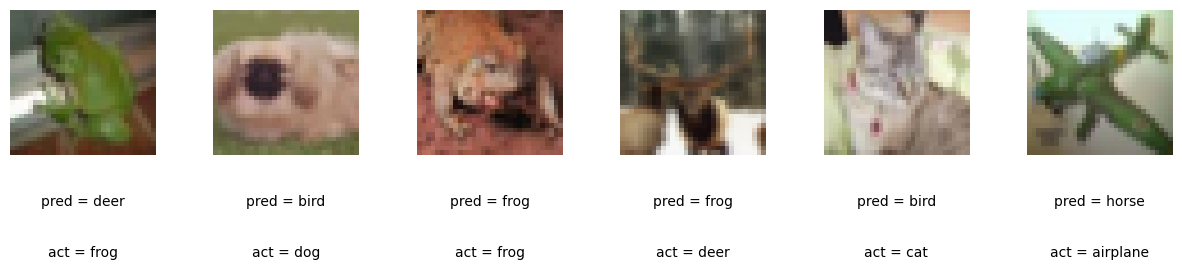

In [14]:
n_to_show = 6
indices = np.random.choice(range(batch_size), n_to_show, replace=False)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = next(iter(testloader))[0][idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img.permute(1, 2, 0))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=458d561e-694b-46db-9401-3185ba610507' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>